# 6 - Attention is All You Need

## Introduction

## Preparing the Data

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

In [4]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [5]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

In [6]:
train_data, valid_data, test_data = Multi30k.splits(exts=('.de', '.en'), 
                                                    fields=(SRC, TRG))

In [7]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device)

## Building the Model

### Encoder

In [10]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 encoder_layer, 
                 self_attention_layer, 
                 positionwise_feedforward_layer, 
                 dropout, 
                 device):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(1000, hid_dim)
        
        self.layers = nn.ModuleList([encoder_layer(hid_dim, 
                                                   n_heads, 
                                                   pf_dim, 
                                                   self_attention_layer, 
                                                   positionwise_feedforward_layer, 
                                                   dropout, 
                                                   device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

### Encoder Layer

In [11]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 self_attention_layer, 
                 positionwise_feedforward_layer, 
                 dropout, 
                 device):
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = self_attention_layer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = positionwise_feedforward_layer(hid_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, src len]
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward, dropout, residual and layer norm
        src = self.layer_norm(src + self.dropout(self.positionwise_feedforward(src)))
        
        #src = [batch size, src len, hid dim]
        
        return src

### Self Attention Layer

In [12]:
class SelfAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, seq len, seq len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
        
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, seq len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, seq len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, seq len, hid dim]
        
        x = self.fc(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x, attention

### Positionwise Feedforward Layer

In [13]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

### Decoder

In [14]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 decoder_layer, 
                 self_attention_layer, 
                 positionwise_feedforward_layer, 
                 dropout, 
                 device):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(1000, hid_dim)
        
        self.layers = nn.ModuleList([decoder_layer(hid_dim, 
                                                   n_heads, 
                                                   pf_dim, 
                                                   self_attention_layer, 
                                                   positionwise_feedforward_layer, 
                                                   dropout, 
                                                   device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

### Decoder Layer

In [15]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 self_attention_layer, 
                 positionwise_feedforward_layer, 
                 dropout, 
                 device):
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = self_attention_layer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = self_attention_layer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = positionwise_feedforward_layer(hid_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward, dropout, residual and layer norm
        trg = self.layer_norm(trg + self.dropout(self.positionwise_feedforward(trg)))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

### Seq2Seq

In [16]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 trg_sos_idx, 
                 device, 
                 max_len = 50):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.trg_sos_idx = trg_sos_idx
        self.device = device
        self.max_len = max_len
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(3)
        
        #trg_pad_mask = [batch size, 1, trg len, 1]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

## Training the Seq2Seq Model

In [17]:
input_dim = len(SRC.vocab)
hid_dim = 128
n_layers = 3
n_heads = 8
pf_dim = 256
dropout = 0.1

enc = Encoder(input_dim, 
              hid_dim, 
              n_layers, 
              n_heads, 
              pf_dim, 
              EncoderLayer, 
              SelfAttentionLayer, 
              PositionwiseFeedforwardLayer, 
              dropout, 
              device)

In [18]:
output_dim = len(TRG.vocab)
hid_dim = 128
n_layers = 3
n_heads = 8
pf_dim = 256
dropout = 0.1

dec = Decoder(output_dim, 
              hid_dim, 
              n_layers, 
              n_heads, 
              pf_dim, 
              DecoderLayer, 
              SelfAttentionLayer, 
              PositionwiseFeedforwardLayer, 
              dropout, 
              device)

In [19]:
src_pad_idx = SRC.vocab.stoi[SRC.pad_token]
trg_pad_idx = TRG.vocab.stoi[TRG.pad_token]
trg_sos_idx = TRG.vocab.stoi[TRG.init_token]

model = Seq2Seq(enc, dec, src_pad_idx, trg_pad_idx, trg_sos_idx, device).to(device)

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 3,767,429 trainable parameters


In [21]:
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)

In [23]:
criterion = nn.CrossEntropyLoss(ignore_index = trg_pad_idx)

In [24]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [25]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [26]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [27]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 10s
	Train Loss: 4.922 | Train PPL: 137.342
	 Val. Loss: 3.570 |  Val. PPL:  35.508
Epoch: 02 | Time: 0m 10s
	Train Loss: 3.396 | Train PPL:  29.852
	 Val. Loss: 2.878 |  Val. PPL:  17.786
Epoch: 03 | Time: 0m 10s
	Train Loss: 2.813 | Train PPL:  16.666
	 Val. Loss: 2.438 |  Val. PPL:  11.449
Epoch: 04 | Time: 0m 11s
	Train Loss: 2.419 | Train PPL:  11.235
	 Val. Loss: 2.164 |  Val. PPL:   8.703
Epoch: 05 | Time: 0m 11s
	Train Loss: 2.144 | Train PPL:   8.532
	 Val. Loss: 2.003 |  Val. PPL:   7.410
Epoch: 06 | Time: 0m 11s
	Train Loss: 1.938 | Train PPL:   6.942
	 Val. Loss: 1.898 |  Val. PPL:   6.671
Epoch: 07 | Time: 0m 10s
	Train Loss: 1.776 | Train PPL:   5.907
	 Val. Loss: 1.818 |  Val. PPL:   6.157
Epoch: 08 | Time: 0m 10s
	Train Loss: 1.640 | Train PPL:   5.156
	 Val. Loss: 1.768 |  Val. PPL:   5.862
Epoch: 09 | Time: 0m 10s
	Train Loss: 1.526 | Train PPL:   4.602
	 Val. Loss: 1.738 |  Val. PPL:   5.686
Epoch: 10 | Time: 0m 10s
	Train Loss: 1.430 | Train PPL

In [28]:
model.load_state_dict(torch.load('tut6-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.743 | Test PPL:   5.714 |


## Inference

In [29]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [30]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(1, n_heads+1):
        
        ax = fig.add_subplot(n_rows, n_cols,i)
        
        _attention = attention.squeeze(0)[i-1].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [31]:
example_idx = 5

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'mann', 'in', 'grün', 'hält', 'eine', 'gitarre', ',', 'während', 'der', 'andere', 'mann', 'sein', 'hemd', 'ansieht', '.']
trg = ['a', 'man', 'in', 'green', 'holds', 'a', 'guitar', 'while', 'the', 'other', 'man', 'observes', 'his', 'shirt', '.']


In [32]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'man', 'in', 'green', 'is', 'holding', 'a', 'guitar', 'while', 'another', 'man', 'looks', 'on', '.', '<eos>']


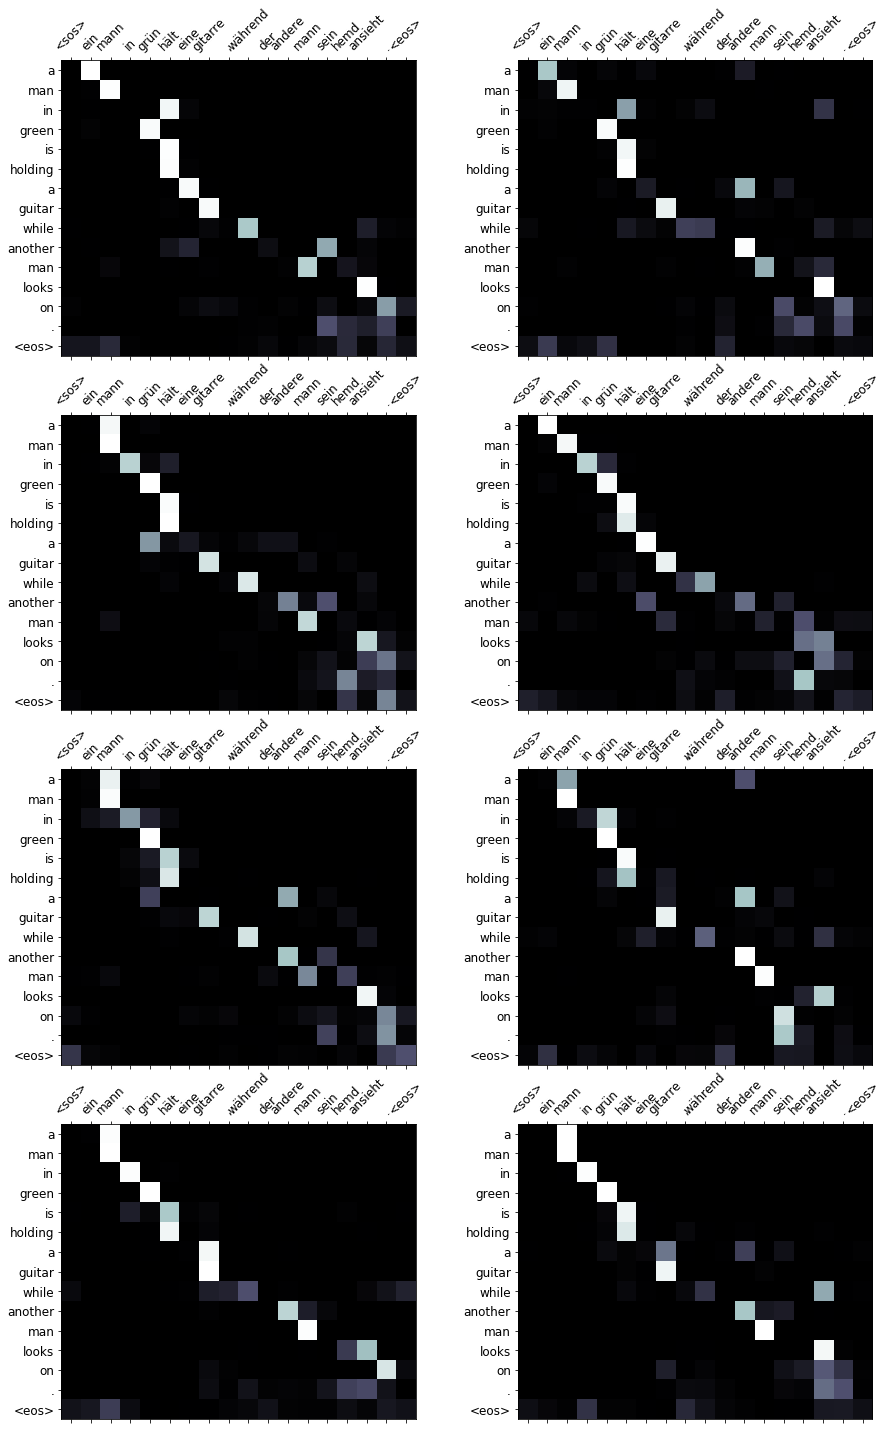

In [33]:
display_attention(src, translation, attention)

In [34]:
example_idx = 6

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'brauner', 'hund', 'rennt', 'dem', 'schwarzen', 'hund', 'hinterher', '.']
trg = ['a', 'brown', 'dog', 'is', 'running', 'after', 'the', 'black', 'dog', '.']


In [35]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'brown', 'dog', 'runs', 'after', 'the', 'black', 'dog', '.', '<eos>']


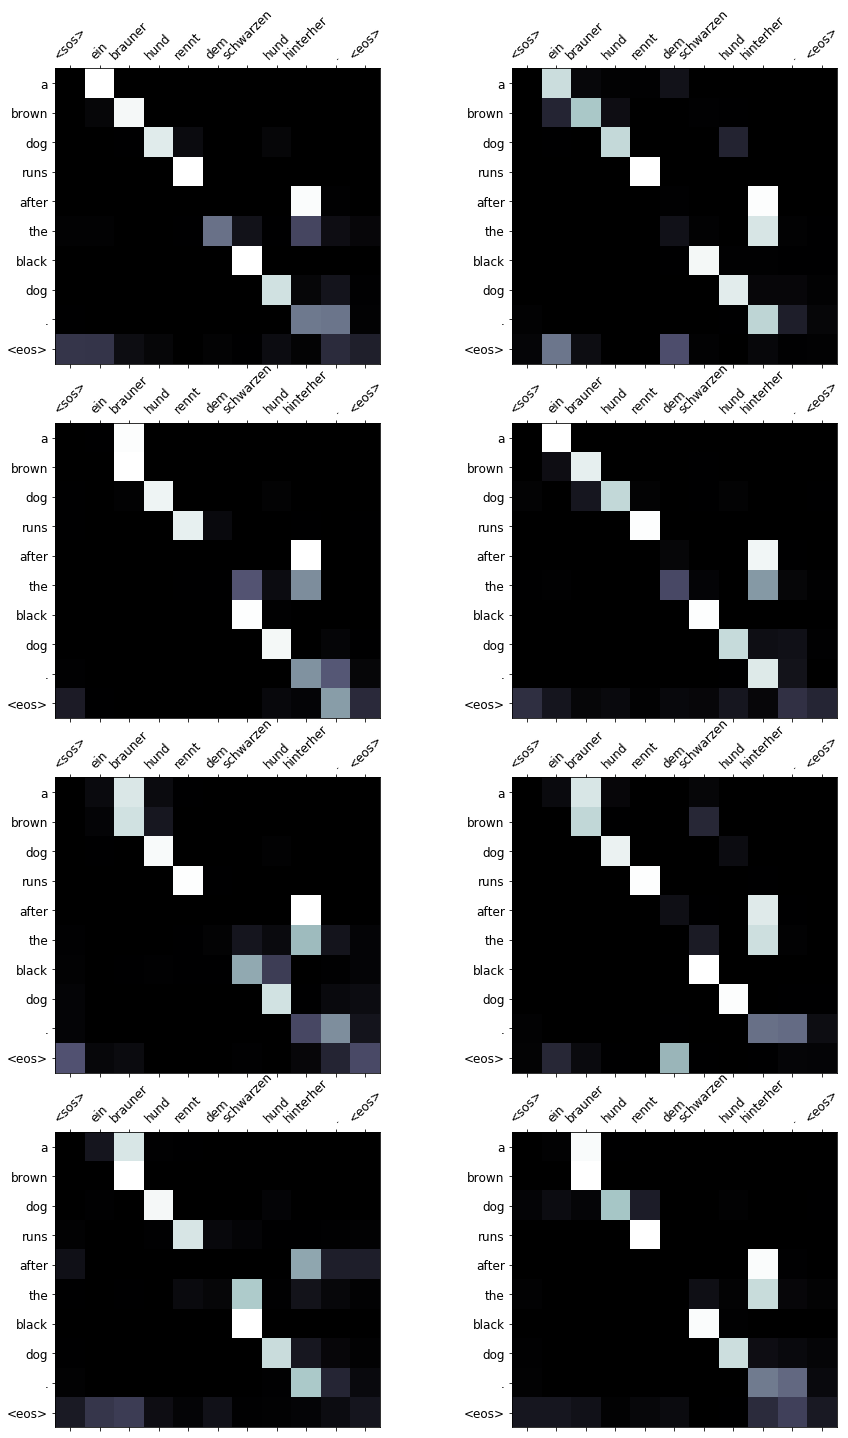

In [36]:
display_attention(src, translation, attention)

In [37]:
example_idx = 10

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.']
trg = ['a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.']


In [38]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'mother', 'and', 'her', 'son', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.', '<eos>']


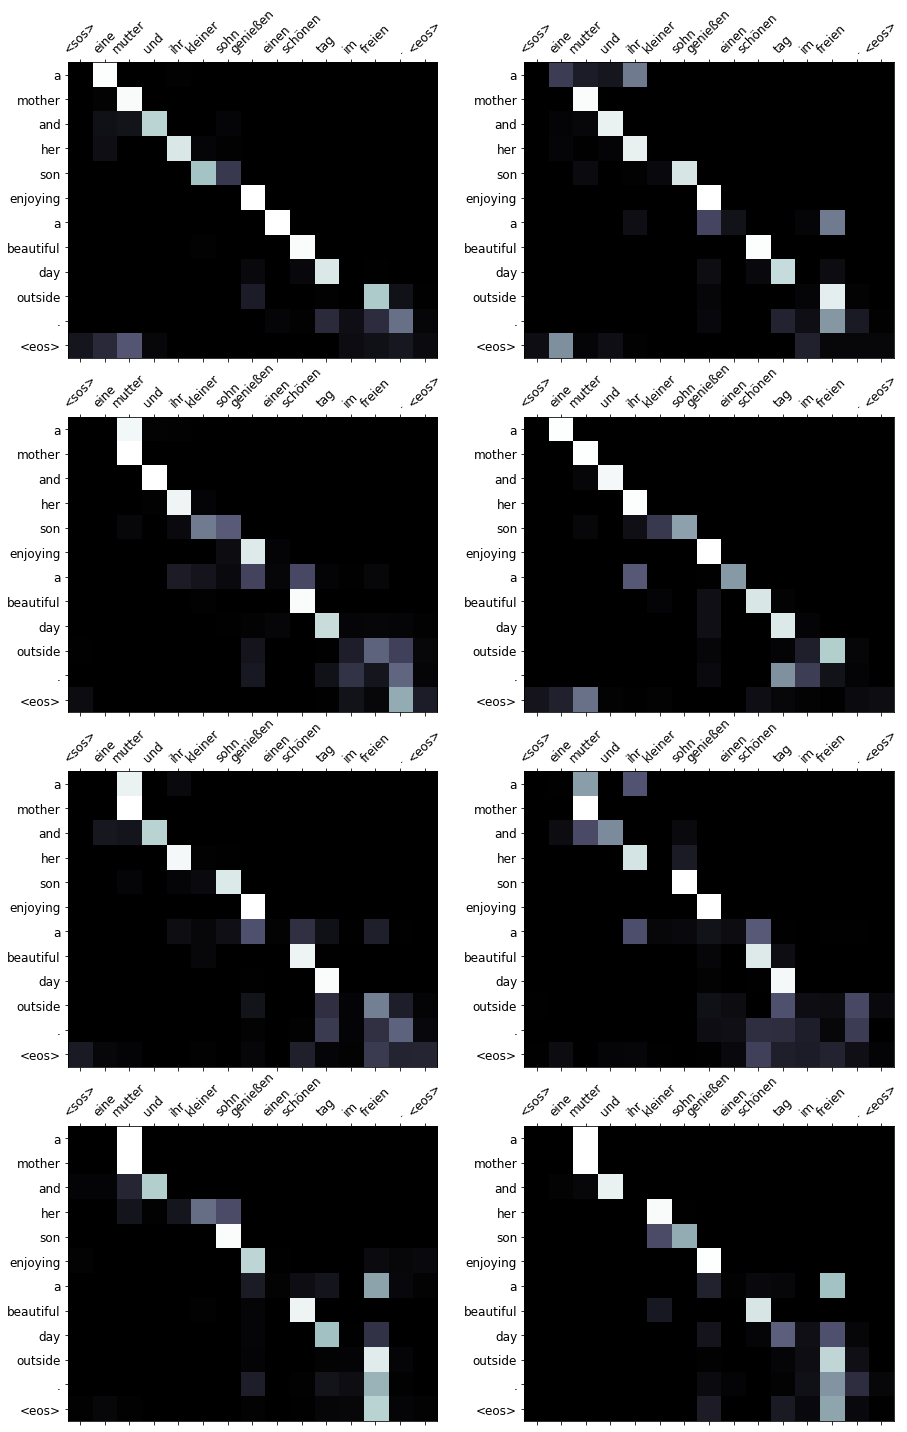

In [39]:
display_attention(src, translation, attention)